Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [3]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [4]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

Посмотрим на какую-нибудь картинку:

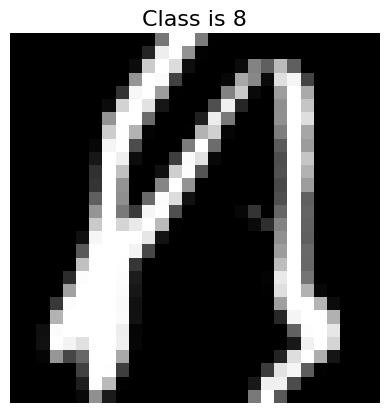

In [5]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

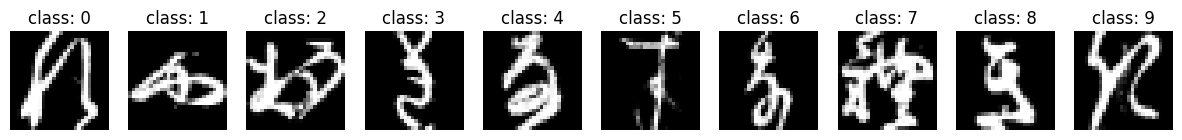

In [6]:
fig, axs = plt.subplots(1, 10, figsize=(15, 5))

for i in range(0, 10):
    axs[i].imshow(trainset[i][0].reshape(28,28,1), cmap="gray")
    axs[i].axis('off')
    axs[i].set_title(f'class: {i}')

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self, act_func = F.relu):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = act_func
        self.last_activation = nn.LogSoftmax(dim=1)  # multiclass classification --> we need probabilities

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.last_activation(x)

        return x

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [8]:
n_w = 28*28*256 + 128 * 256 + 10 * 128
n_b = 256 + 128 + 10
print(f'Here we have {n_w} weights and {n_b} biases',
      f'So overall we have {n_w+n_b} parameters', sep='\n')

Here we have 234752 weights and 394 biases
So overall we have 235146 parameters


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [9]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [10]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
#optimizer = torch.optim.SGD(fc_net.parameters(), lr=lr)
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [11]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0

    for images, labels in trainloader: # batch of pictures
        optimizer.zero_grad() # not summing up grads!
        outputs = fc_net(images) # predicting
        loss = loss_function(outputs, labels)
        loss.backward() # gradients calculation
        optimizer.step() # GD step

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6227
Epoch=2 loss=0.2872
Epoch=3 loss=0.1978
Epoch=4 loss=0.1451
Epoch=5 loss=0.1104
Epoch=6 loss=0.0845
Epoch=7 loss=0.0636
Epoch=8 loss=0.0507
Epoch=9 loss=0.0351
Epoch=10 loss=0.0251


In [12]:
get_accuracy(fc_net, testloader)

0.8992

Accuracy $\approx$ 90,7%, not that bad for such a simple network and just 10 epochs, however, dynamics matter. We can have a look at the training curve:

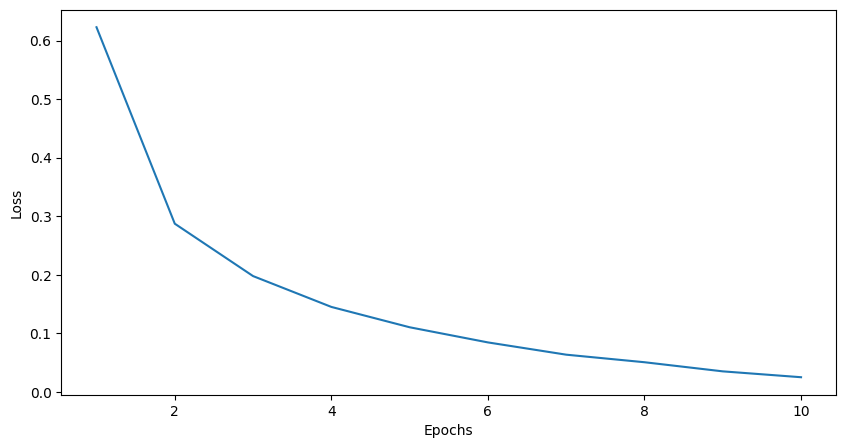

In [13]:
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(n_epochs)], loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Seems like we were on the right way, even though we can seen that the speed of decline is slowing down.

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [15]:
mean = torch.mean(next(iter(trainloader))[0]) # calculate mean
std = torch.std(next(iter(trainloader))[0]) # calculate std
print(mean, std)

# normalilzation
transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

tensor(0.1869) tensor(0.3425)


In [28]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)

In [29]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0

    for images, labels in trainloader: # batch of pictures
        optimizer.zero_grad() # not summing up grads!
        outputs = fc_net(images) # predicting
        loss = loss_function(outputs, labels)
        loss.backward() # gradients calculation
        optimizer.step() # GD step

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.4493
Epoch=2 loss=0.1864
Epoch=3 loss=0.1208
Epoch=4 loss=0.0828
Epoch=5 loss=0.0575
Epoch=6 loss=0.0386
Epoch=7 loss=0.0285
Epoch=8 loss=0.0196
Epoch=9 loss=0.0145
Epoch=10 loss=0.0116


In [30]:
get_accuracy(fc_net, testloader)

0.9082

Как изменилась `accuracy` после нормализации?

Improved by ~0.8%! However, it also depends on the run: with only 10 epochs results of accuracy difference can vary very much

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [39]:
import time

In [43]:
n_epochs = 10
lr = 0.001
loss_function = nn.CrossEntropyLoss()

dict_act_func = {'sigmoid': F.sigmoid, 'GELU': F.gelu, 'Tanh': F.tanh}
loss_history = {'sigmoid': [], 'GELU': [], 'Tanh': []}

for act_func in dict_act_func.items():
    print('------------------------------------',
          f'Function: {act_func[0]}', sep='\n')

    # defining a network
    fc_net = FCNet(act_func = act_func[1])
    optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)

    # training loop
    start = time.time()
    for epoch in range(n_epochs):
        epoch_loss = 0

        for images, labels in trainloader: # batch of pictures
            optimizer.zero_grad() # not summing up grads!
            outputs = fc_net(images) # predicting
            loss = loss_function(outputs, labels)
            loss.backward() # gradients calculation
            optimizer.step() # GD step

            epoch_loss += loss.item()

        loss_history[act_func[0]].append(epoch_loss/len(trainloader))
        print(f"Epoch={epoch+1} loss={loss_history[act_func[0]][epoch]:.4f}")
        
    end = time.time()
    print(f'Time for 10 epochs: {end - start}')
    # accuracy
    print(f'Accuracy for function {act_func[0]}: {get_accuracy(fc_net, testloader)}')


------------------------------------
Function: sigmoid
Epoch=1 loss=0.9520
Epoch=2 loss=0.3806
Epoch=3 loss=0.2548
Epoch=4 loss=0.1827
Epoch=5 loss=0.1337
Epoch=6 loss=0.0982
Epoch=7 loss=0.0725
Epoch=8 loss=0.0524
Epoch=9 loss=0.0384
Epoch=10 loss=0.0279
Time for 10 epochs: 182.54356169700623
Accuracy for function sigmoid: 0.8954
------------------------------------
Function: GELU
Epoch=1 loss=0.4284
Epoch=2 loss=0.1610
Epoch=3 loss=0.0996
Epoch=4 loss=0.0650
Epoch=5 loss=0.0460
Epoch=6 loss=0.0311
Epoch=7 loss=0.0176
Epoch=8 loss=0.0138
Epoch=9 loss=0.0123
Epoch=10 loss=0.0137
Time for 10 epochs: 172.0778112411499
Accuracy for function GELU: 0.903
------------------------------------
Function: Tanh
Epoch=1 loss=0.5063
Epoch=2 loss=0.1964
Epoch=3 loss=0.1178
Epoch=4 loss=0.0720
Epoch=5 loss=0.0454
Epoch=6 loss=0.0300
Epoch=7 loss=0.0178
Epoch=8 loss=0.0101
Epoch=9 loss=0.0078
Epoch=10 loss=0.0047
Time for 10 epochs: 162.51956176757812
Accuracy for function Tanh: 0.8955


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

$$sigmoid(x) = \frac{1}{1+ exp(-x)} $$

$$tanh(x) = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)} $$

$$GELU(x) = 0.5*x*(1+tanh(sqrt(2/\pi))*(x + 0.044715*x^3)) $$


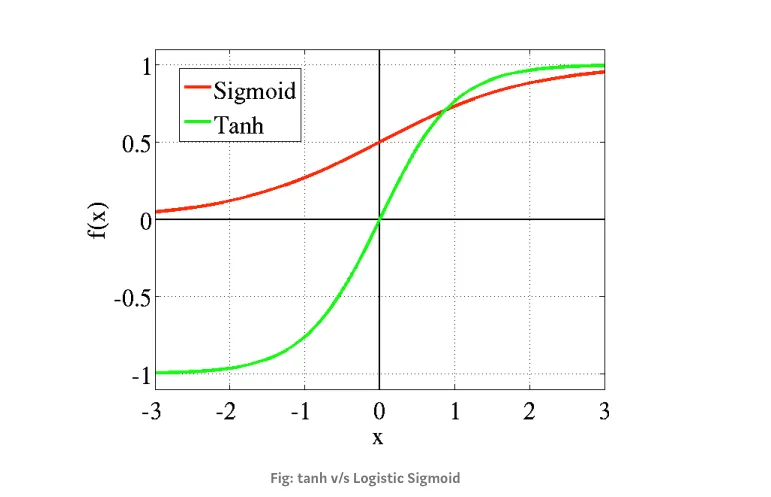

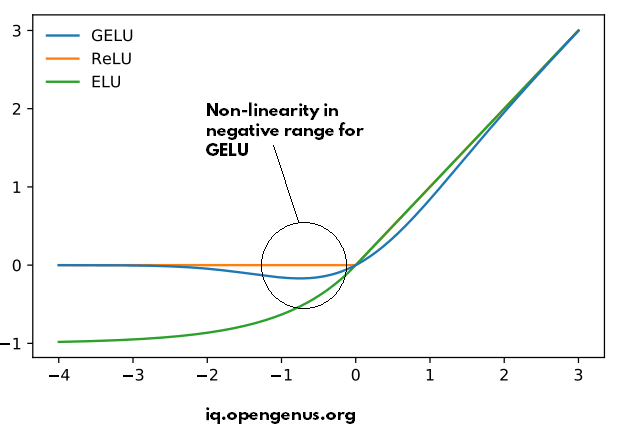

As we can see above, the best result was obtained with *GELU* activation function. This function is quite close to ReLu, but has a nonlinear region. Let's have a look at the training curves:

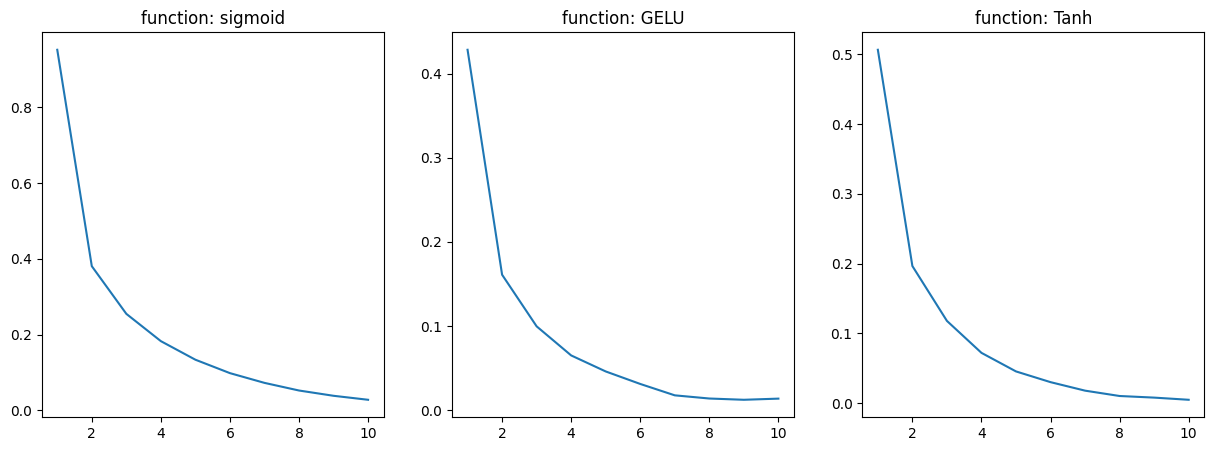

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, name in enumerate(loss_history.keys()):
    axs[i].plot([i+1 for i in range(n_epochs)], loss_history[name])
    axs[i].set_title(f'function: {name}')

We can notice that when sigmoid and tanh have more or less similar trends closer to 10th epoch, GELU curve is almost reaching a plato. Thus we can expect more improvements from sigmoid and tanh with more epochs, but not GELU.

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [46]:
n_epochs = 10
lr = 0.001
loss_function = nn.CrossEntropyLoss()

dict_optim = {'Adam': torch.optim.Adam, 'RMSprop': torch.optim.RMSprop,
              'Adagrad': torch.optim.Adagrad}
loss_history = {'Adam': [], 'RMSprop': [], 'Adagrad': []}

for optim in dict_optim.items():
    print('------------------------------------',
          f'Optimizer: {optim[0]}', sep='\n')

    # defining a network
    fc_net = FCNet(act_func = F.gelu)
    optimizer = optim[1](fc_net.parameters(), lr=lr)

    # training loop
    start = time.time()
    for epoch in range(n_epochs):
        epoch_loss = 0

        for images, labels in trainloader: # batch of pictures
            optimizer.zero_grad() # not summing up grads!
            outputs = fc_net(images) # predicting
            loss = loss_function(outputs, labels)
            loss.backward() # gradients calculation
            optimizer.step() # GD step

            epoch_loss += loss.item()

        loss_history[optim[0]].append(epoch_loss/len(trainloader))
        print(f"Epoch={epoch+1} loss={loss_history[optim[0]][epoch]:.4f}")

    end = time.time()
    print(f'Time for 10 epochs: {end - start}')

    # accuracy
    print(f'Accuracy for optimizer {optim[0]}: {get_accuracy(fc_net, testloader)}')


------------------------------------
Optimizer: Adam
Epoch=1 loss=0.4243
Epoch=2 loss=0.1688
Epoch=3 loss=0.1070
Epoch=4 loss=0.0703
Epoch=5 loss=0.0452
Epoch=6 loss=0.0330
Epoch=7 loss=0.0224
Epoch=8 loss=0.0185
Epoch=9 loss=0.0118
Epoch=10 loss=0.0097
Time for 10 epochs: 166.6094777584076
Accuracy for optimizer Adam: 0.9028
------------------------------------
Optimizer: RMSprop
Epoch=1 loss=0.3398
Epoch=2 loss=0.1353
Epoch=3 loss=0.0844
Epoch=4 loss=0.0559
Epoch=5 loss=0.0365
Epoch=6 loss=0.0299
Epoch=7 loss=0.0213
Epoch=8 loss=0.0163
Epoch=9 loss=0.0177
Epoch=10 loss=0.0132
Time for 10 epochs: 166.39483451843262
Accuracy for optimizer RMSprop: 0.9061
------------------------------------
Optimizer: Adagrad
Epoch=1 loss=0.6918
Epoch=2 loss=0.4442
Epoch=3 loss=0.3885
Epoch=4 loss=0.3560
Epoch=5 loss=0.3323
Epoch=6 loss=0.3153
Epoch=7 loss=0.3007
Epoch=8 loss=0.2887
Epoch=9 loss=0.2781
Epoch=10 loss=0.2692
Time for 10 epochs: 164.34832429885864
Accuracy for optimizer Adagrad: 0.8135


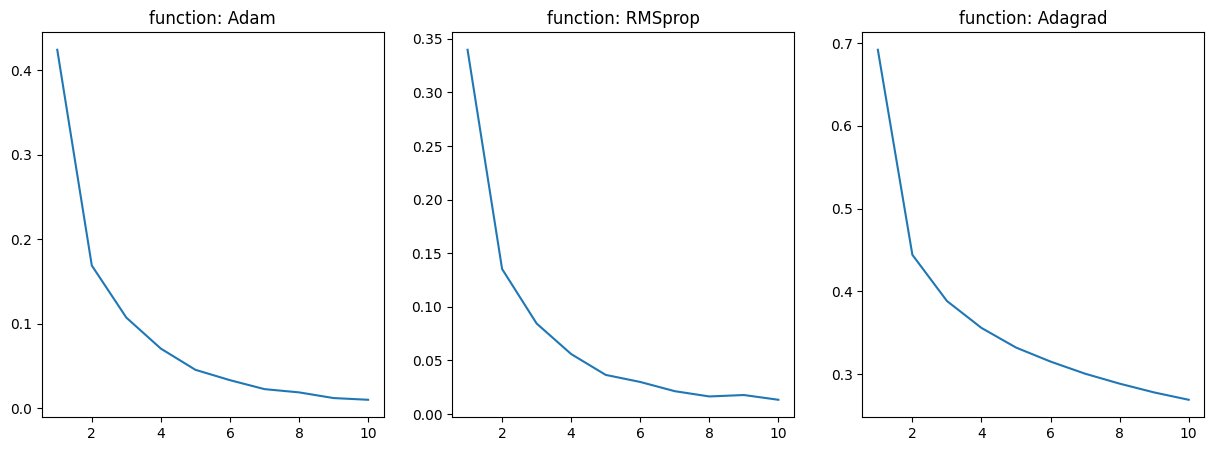

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, name in enumerate(loss_history.keys()):
    axs[i].plot([i+1 for i in range(n_epochs)], loss_history[name])
    axs[i].set_title(f'function: {name}')

RMSprop showed the best result, but the loss plot is a bit bumpy, so we can assume that it might cause some instability. Thus in the next task we will use Adam which showed almost the same result, but have more reliable plot (judging by 10 epochs which is very few though..)

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [48]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # если элемент x < 0, то 0, если >= 0, то x
        x[x < 0] = 0
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [55]:
n_epochs = 10
lr = 0.001
loss_function = nn.CrossEntropyLoss()

dict_act_func = {'Custom Relu': CustomReLU(), 'Relu': F.relu}
loss_history = {'Relu': [], 'Custom Relu': []}

for func in dict_act_func.items():
    print('------------------------------------',
          f'Function: {func[0]}', sep='\n')

    # defining a network
    fc_net = FCNet(act_func = func[1])
    optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)

    # training loop
    start = time.time()
    for epoch in range(n_epochs):
        epoch_loss = 0

        for images, labels in trainloader: # batch of pictures
            optimizer.zero_grad() # not summing up grads!
            outputs = fc_net(images) # predicting
            loss = loss_function(outputs, labels)
            loss.backward() # gradients calculation
            optimizer.step() # GD step

            epoch_loss += loss.item()

        loss_history[func[0]].append(epoch_loss/len(trainloader))
        print(f"Epoch={epoch+1} loss={loss_history[func[0]][epoch]:.4f}")

    end = time.time()
    print(f'Time for 10 epochs: {end - start}')

    # accuracy
    print(f'Accuracy for {func[0]}: {get_accuracy(fc_net, testloader)}')


------------------------------------
Function: Custom Relu
Epoch=1 loss=0.4558
Epoch=2 loss=0.1890
Epoch=3 loss=0.1215
Epoch=4 loss=0.0827
Epoch=5 loss=0.0566
Epoch=6 loss=0.0377
Epoch=7 loss=0.0279
Epoch=8 loss=0.0201
Epoch=9 loss=0.0201
Epoch=10 loss=0.0151
Time for 10 epochs: 186.58788967132568
Accuracy for Custom Relu: 0.9051
------------------------------------
Function: Relu
Epoch=1 loss=0.4482
Epoch=2 loss=0.1838
Epoch=3 loss=0.1211
Epoch=4 loss=0.0824
Epoch=5 loss=0.0553
Epoch=6 loss=0.0394
Epoch=7 loss=0.0283
Epoch=8 loss=0.0198
Epoch=9 loss=0.0174
Epoch=10 loss=0.0136
Time for 10 epochs: 164.6117718219757
Accuracy for Relu: 0.9068


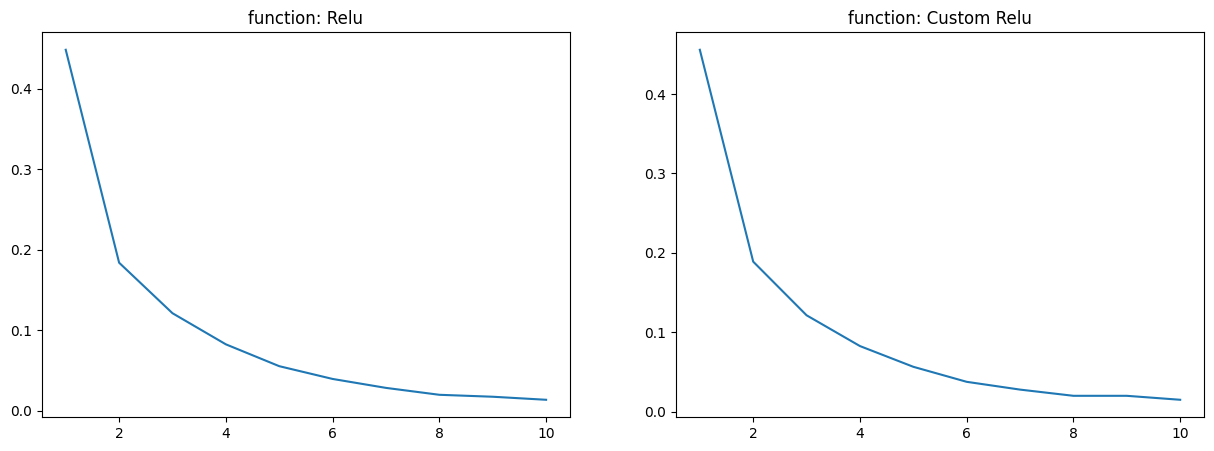

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i, name in enumerate(loss_history.keys()):
    axs[i].plot([i+1 for i in range(n_epochs)], loss_history[name])
    axs[i].set_title(f'function: {name}')

As we can see, accuracy and plot are quite similar between our custom function and build-in function from torch. It's also interesting to notice that our custom function works slower than more effectively implemented relu from torch.

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

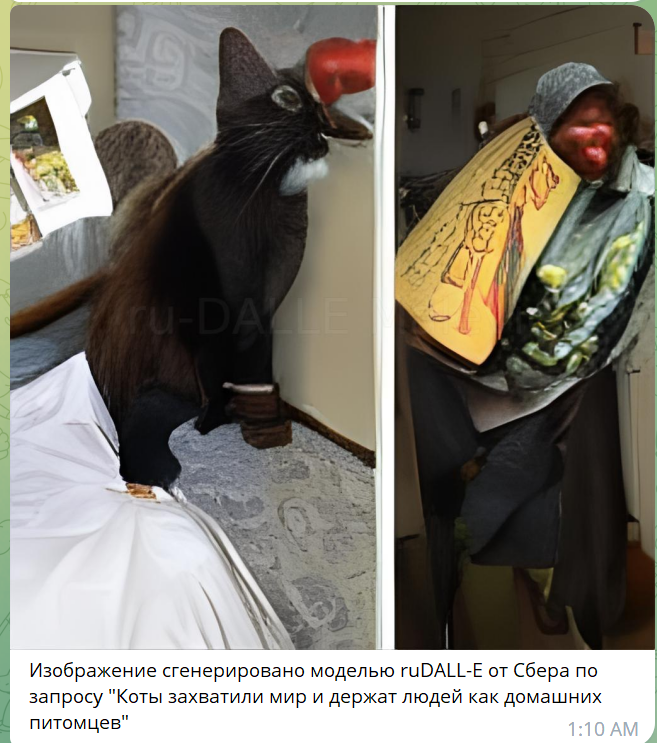

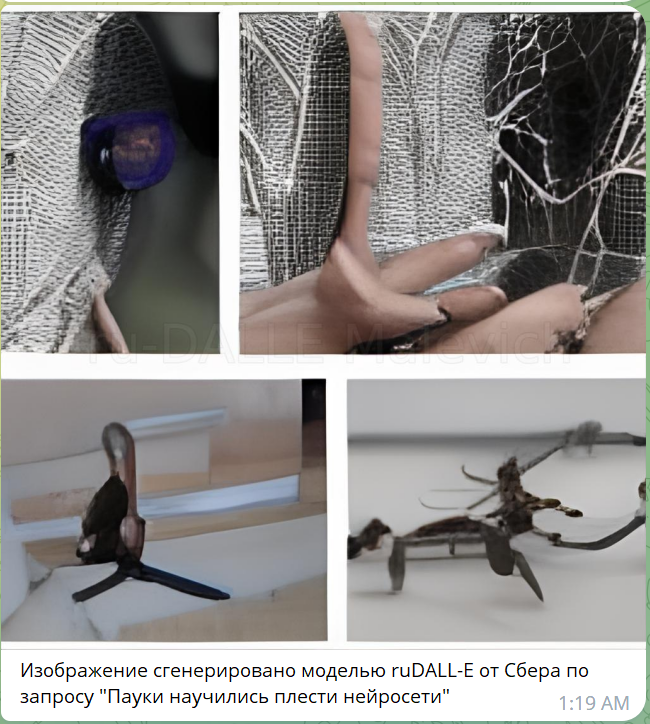

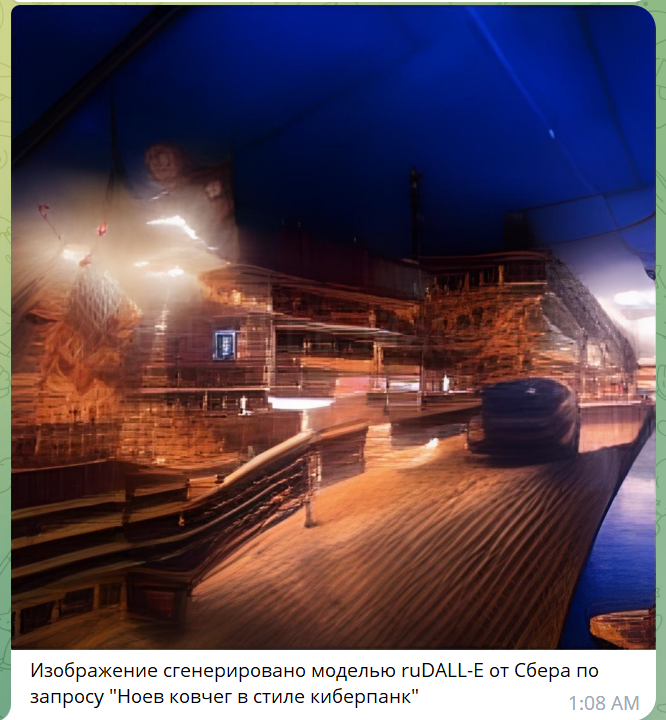